In [1]:
import tensorflow as tf
tf.enable_eager_execution()
import src.infovae as infovae
import src.mri as mri

import numpy as np
import matplotlib.pyplot as plt

/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/MNIST_data/", one_hot=False)

Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz


In [77]:
nn = infovae.InfoVAE(6, 8, 4)
d = int(0.10*32*32*1)
f = mri.MRI(N=d, stddev=0.0001)

In [85]:
A = tf.random_normal((d//2, d//2))

In [86]:
def calc_grad(r, y, coeffs):
    with tf.GradientTape() as tape:
        p_real, _ = nn.estimate_density(r)
        h = f(r)
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(h - y), axis=1))
        prior_loss = tf.reduce_mean(tf.abs(p_real))
        sparse_loss = tf.reduce_mean(tf.reduce_sum(
            tf.abs(tf.matmul(h[:, :tf.shape(h)[-1]//2], A)), axis=1))
        tv_loss = tf.reduce_mean(tf.image.total_variation(r))
        print('\rRecon loss: {:.4f}, Prior loss: {:.4f},'
              ' Sparse loss: {:.4f}, TV loss {:.4f}'.format(
                  recon_loss, prior_loss, sparse_loss, tv_loss), end='', flush=True)
        
        agg_loss = coeffs[0]*recon_loss+coeffs[1]*prior_loss+coeffs[2]*sparse_loss+coeffs[3]*tv_loss
    grad = tape.gradient(agg_loss, r)
    return [grad], tf.reduce_mean(recon_loss)

opt = tf.train.AdamOptimizer(0.1)

In [87]:
def reconstruct(x, N=100, coeffs=[1,0,0,0]):
    y = f(x)
    r = tf.contrib.eager.Variable(tf.nn.sigmoid(tf.random_normal(tf.shape(x))))
    for i in range(N):
        grads, loss = calc_grad(r, y, coeffs)
        opt.apply_gradients(zip(grads, [r]), global_step=tf.train.get_or_create_global_step())
        
#         if i % 10 == 0:
#             print('\rStep: {}, Recon loss: {:.4f}'.format(i, loss), end='', flush=True)
#             plt.figure()
#             plt.imshow(r[0, :, :, 0], interpolation='nearest', cmap='gray')
    return r

In [88]:
model_path = '/home/act65/Documents/infovae/4/'
variables = nn.encoder.variables + nn.decoder.variables
checkpoint = tf.contrib.eager.Checkpoint(**{var.name: var for var in variables})
checkpoint.restore(tf.train.latest_checkpoint(model_path))

In [89]:
# nn.encoder.variables[0][0,0,0,:]

Recon loss: 0.0060, Prior loss: 0.2742, Sparse loss: 524.1386, TV loss 517.0046

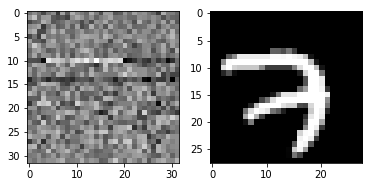

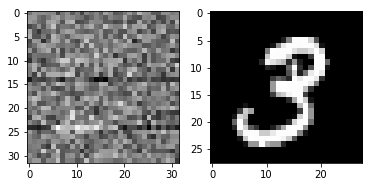

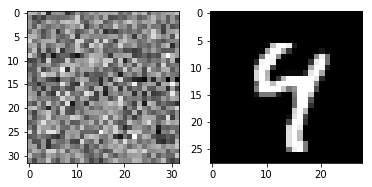

In [90]:
inputs = tf.constant(infovae.InfoVAE.preprocess(mnist.train.images[0:3, ...]))
recon = reconstruct(inputs, 100, coeffs=[1,0,0,0])  # no regularisation, just the data

for i in range(3):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(recon[i, :, :, 0], interpolation='nearest', cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mnist.train.images[i].reshape((28,28)), interpolation='nearest', cmap='gray')

Recon loss: 0.0120, Prior loss: 0.0262, Sparse loss: 523.1169, TV loss 2665.2527

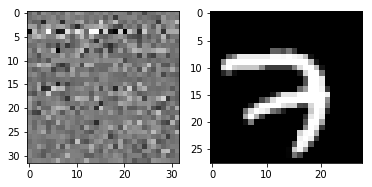

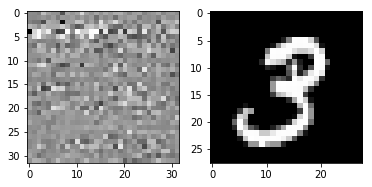

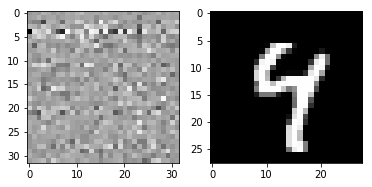

In [91]:
inputs = tf.constant(infovae.InfoVAE.preprocess(mnist.train.images[0:3, ...]))
recon = reconstruct(inputs, 100, coeffs=[1,1000,0,0])  # learned prior

for i in range(3):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(recon[i, :, :, 0], interpolation='nearest', cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mnist.train.images[i].reshape((28,28)), interpolation='nearest', cmap='gray')

Recon loss: 7.9435, Prior loss: 0.2607, Sparse loss: 366.4680, TV loss 519.3538

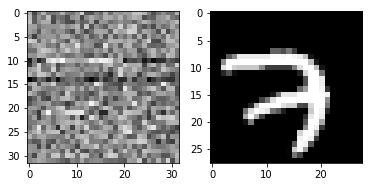

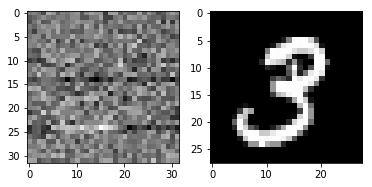

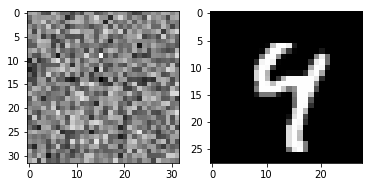

In [92]:
inputs = tf.constant(infovae.InfoVAE.preprocess(mnist.train.images[0:3, ...]))
recon = reconstruct(inputs, 100, coeffs=[1,0,0.1,0])  # CS with prior

for i in range(3):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(recon[i, :, :, 0], interpolation='nearest', cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mnist.train.images[i].reshape((28,28)), interpolation='nearest', cmap='gray')

Recon loss: 2.8577, Prior loss: 0.2733, Sparse loss: 504.7089, TV loss 95.4514

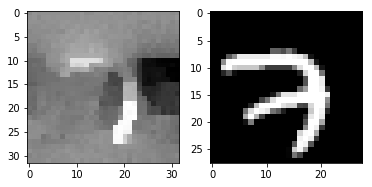

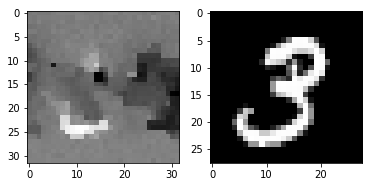

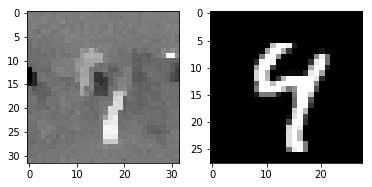

In [94]:
inputs = tf.constant(infovae.InfoVAE.preprocess(mnist.train.images[0:3, ...]))
recon = reconstruct(inputs, 100, coeffs=[1,0,0,1])  # CS with prior

for i in range(3):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(recon[i, :, :, 0], interpolation='nearest', cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mnist.train.images[i].reshape((28,28)), interpolation='nearest', cmap='gray')